<a href="https://colab.research.google.com/github/smc395/ics691_big_data_project/blob/main/Ray_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction
This tutorial is for ICS691 Big Data Analytics Fall 2022 semester project. I will be evaluating [Ray](https://www.ray.io/), an open-source unified compute framework.

## Dataset
The dataset that I will be using in this project is the Flight Delay dataset from Kaggle. It contains flight data from January 2018 to July 2022. In addition to the flight data, the dataset contains `Airlines.csv`, a CSV that contains the [IATA](https://www.iata.org/en/publications/directories/code-search/) code and name for 1,570 airlines.The flight data is stored in the Apache parquet format.

## Big Data Justification
This is a big data project because the parquet dataset files themselves are roughly 200 MB each and taken together would be 1GB. Processing this entire dataset in RAM would be slow and the dataset authors seemingly update this dataset every couple of months meaning that as time goes on, the amount of data will grow. Repeating this analysis overtime would therefore need resources and/or methods to perform this analysis at scale and speed.

## Project Goal
The goal of this tutorial will be to use Ray to do some exploratory data analysis and visualization for different airlines. It will demonstrate some of the key concepts within the Ray Dataset library and Ray Core of this framework.

# References
1. [Ray Documentation](https://docs.ray.io/en/latest/ray-overview/index.html)
2. [Downloading Kaggle datasets directly into Google Colab](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)
3. [Kaggle Flight Delay Dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022)
4. [Apache Parquet](https://parquet.apache.org/docs/overview/motivation/)
5. [Apache Arrow](https://arrow.apache.org/docs/format/Columnar.html)
6. [Moritz et al. - Ray Paper](https://www.usenix.org/system/files/osdi18-moritz.pdf)

# Getting Started
To start we will install the necessary libraries and import the necessary dependencies to do the analysis.

In [1]:
# Install dependencies
%%capture --no-display
!pip install -U "pyarrow<7.0.0"
!pip install ray
!pip install kaggle

In [2]:
# Import dependencies and create Ray cluster
import os
import pyarrow as pa
import pyarrow.compute as pc
import matplotlib.pyplot as plt
import ray

In [ ]:
# Determine how many CPUs we have to work with and distribute across
os.cpu_count()

2

In [ ]:
# Determine if and what type of GPU we have to work with
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5bb87bd1-3f50-d07e-acb5-8561116d037c)


## Import Dataset to Colab
We will download the dataset to Google Drive using the Kaggle API so that the dataset can be used in this Jupyter notebook.

In [ ]:
# Create a folder named kaggle in your Google Drive and place the kaggle.json
# from your Kaggle account before runnig this code block.
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'
os.chdir('/gdrive/MyDrive/kaggle')

'/content'

In [ ]:
# This will connect the Colab notebook to your Google Drive account
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# Download the dataset to Google Drive kaggle folder.
# We do this because Colab times out after 30 min wiping all data.
!kaggle datasets download -d robikscube/flight-delay-dataset-20182022

100% 3.72G/3.73G [00:28<00:00, 170MB/s]
100% 3.73G/3.73G [00:28<00:00, 142MB/s]


In [ ]:
# Set the path of where the zipped dataset is located
zip_path = '/gdrive/MyDrive/kaggle/flight-delay-dataset-20182022.zip'

In [ ]:
# Create a flight_data folder in Google Colab if it does not already exist to hold the data files.
# Copy the zip folder from your Google Drive to Colab.
if not os.path.exists('/content/flight_data'):
  os.mkdir('/content/flight_data')
os.chdir('/content/flight_data')
!cp '{zip_path}' .

In [ ]:
# Unzip the dataset in Colab. This will take some time.
# It is recommended to delete the raw folder and keep only one file format of the data to save disk space.
!unzip -q 'flight-delay-dataset-20182022.zip'

# Ray
## Introduction
Ray [\[1\]](https://docs.ray.io/en/latest/ray-overview/index.html) was designed to help address challenges that come with the scale and the need for efficient processing of large amounts of data for reinforcement learning applications [\[6\]](https://www.usenix.org/system/files/osdi18-moritz.pdf). It was built for Python, but also currently suppors Java. Ray has different libraries to handle different steps within the machine learning pipeline (loading data, wrangling it, training a model, model validation, and serving the model). Ray is currently working on toolkit to unify these steps end-to-end, however each library can be used on its own. 

## Programming Model
Ray is able to scale and run in a computationally efficient way because of the programming model it employs. This model is comprises Tasks, Actors, and Objects to accomplish computations in a distributed manner. These three are what make up Ray Core.

Using Ray, we can scale programs from a laptop to a cluster without needing to modify our program as Ray will handle the parallelization and repartitioning behind the scenes on a cluster such as Amazon Web Services (AWS), Google Cloud Platform (GCP), and Kubernetes.

## Starting Ray
To start using Ray, we first have to initialize a Ray cluster by calling `init()`. This only needs to be called once during the entire usage of Ray. To restart the Ray cluster, call `shutdown()`.

In [3]:
ray.init()

2022-12-12 07:29:26,864	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.8.16
Ray version:,2.1.0


In [4]:
# check that the ray cluster has properly initialized
assert ray.is_initialized

## Tasks
Tasks are functions that can be executed in a distributed manner. This can be accomplished by using the decorator `@ray.remote`. The function will now be a remote function that can be run on clusters. For example,

In [5]:
# Use the `@ray.remote` decorator to turn any function into a remote function
@ray.remote
def foo(a):
  return a

To execute the function, call `function.remote(args)` and pass in any arguments that `function` takes into `remote()`.

In [6]:
bar = foo.remote('hello world')
bar

ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000)

## Objects
As you can see, `remote()` returns an `ObjectRef`. This is a future remote object, meaning that something will be returned from Ray. It is essentially a pointer or a unique ID that can be used to refer to a remote object without seeing its value. It is a similar concept as JavaScript [Promises](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Promise).

Remote objects can be stored anywhere in a Ray cluster and cached in Ray’s distributed shared-memory object store, and there is one object store per node in the cluster. In the cluster setting, a remote object can live on one or many nodes, independent of who holds the object ref(s) [\[1\]](https://docs.ray.io/en/latest/ray-core/objects.html#objects-in-ray).

To return the value, we use `get()` on the remote object.

In [7]:
print(ray.get(bar))

hello world


## Actor
Actors are stateful objects. You create them by using the same `ray.remote` decorator for Python classes. You interact with the remote class object by calling `remote()` as well. As with any Python class, you can define methods within the class to be called. To do this, you use the pattern `actor.method.remote()`.

In [5]:
from random import randint

In [6]:
# Turn this class into a Ray Actor
@ray.remote
class RayCounter:
  def __init__(self, num):
    self.id = num
    self.counter = 0

  def increment(self):
    self.counter += 1
  
  def get_counter(self) -> int:
    return self.counter

  def get_id(self) -> int:
    return self.id

In [7]:
# Create three Counter classes with different ids
ray_counters = [RayCounter.remote(num) for num in range(3)]
ray_counters

[Actor(RayCounter, 704030b18da22640f08d6c7301000000),
 Actor(RayCounter, c0f6a1524d7bd221657c6eae01000000),
 Actor(RayCounter, 20f7cbc2a9028e3df19772a101000000)]

In [8]:
# Create a Ray task that will increment the actor's counter over time
# Note that here you can specify the usage of GPUs for this task
@ray.remote(num_gpus=1)
def worker(counter_actors, i):
  counter_actors[i].increment.remote()

In [9]:
# 10,000 times increment a random Counter actor 
count = 0
while count < 10_000:
  i = randint(0, 2)  
  worker.remote(ray_counters, i) # this will distribute the task of incrementing the actor's state over clusters
  count += 1
print(f'\nAfter {count} iterations...')

for counter in ray_counters:
  id_ref = counter.get_id.remote()
  counter_ref = counter.get_counter.remote()   
  print(f'Counter {ray.get(id_ref)} value is {ray.get(counter_ref)}')


After 10000 iterations...
Counter 0 value is 88
Counter 1 value is 81
Counter 2 value is 80


In [25]:
# It seems to take some time depending on the number of taks you have for all
# task to finish and finally return what we expected for the Counter actors 
for counter in ray_counters:
  id_ref = counter.get_id.remote() # call the actor's get_id() method
  counter_ref = counter.get_counter.remote() # call the actor's get_counter() method
  print(f'Counter {ray.get(id_ref)} value is {ray.get(counter_ref)}') # use the actor_obj_ref to get the value returned

Counter 0 value is 3335
Counter 1 value is 3351
Counter 2 value is 3314


In [ ]:
ray.shutdown() # stop the ray cluster for this example

A table summarizing  Ray Core from Mortiz et al. paper [\[6\]](https://www.usenix.org/system/files/osdi18-moritz.pdf).

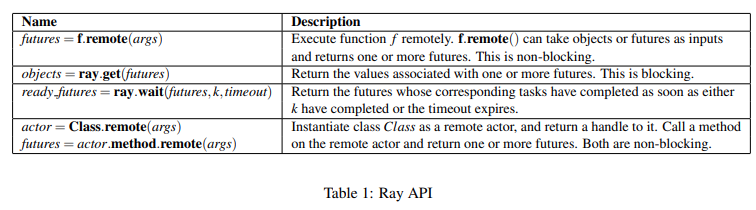

# Flight Data Set Analysis Using Ray
## Reading Parquet Dataset
### What is Parquet?
Apache Parquet is a data storage format where data is stored as columns instead of rows. For example, in a row based stoarge, you would see a table as names and ages as:

| Name | Age |
|------|-----|
| John | 18  | 
| Jane | 20  |
| Joe  | 21  |

Using parquet, the data will be stored as such:

|   |   |   |   |   |
|------|------|------|-----|---|
| Name | John | Jane | Joe |   |
| Age  | 18   | 20   | 21  |   |

Storing data as columnar can help with analysis since when loading the data into memory for analysis, you can keep one continous block of memory (leading to more efficient reads). In addition, parquet is built to support compression and encoding efficiently.

## Columns from Flight Dataset Used
For the analysis, we will be using these columns
*   Year
*   Quarter (1-4)
*   Month
*   DayofWeek
*   FlightDate (yyymmdd)
*   Operating_Airline (aka Unique Carrier Code)
*   Airline (Airline name)
*   Cancelled (1=Yes, 0=No)
*   Diverted  (1=Yes, 0=No)
*   DepDelay (Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.)
*   ArrDelay (Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.)
*   Dest (Destination airport)
*   Origin (Origin airport)



In [ ]:
#parquet_file_paths = [
#'/content/flight_data/Combined_Flights_2018.parquet'
#,'/content/flight_data/Combined_Flights_2019.parquet'
#,'/content/flight_data/Combined_Flights_2020.parquet'
#,'/content/flight_data/Combined_Flights_2021.parquet'
#,'/content/flight_data/Combined_Flights_2022.parquet'
#]

['Combined_Flights_2021.csv',
 'Combined_Flights_2018.csv',
 'Airlines.csv',
 'Combined_Flights_2020.csv',
 'raw',
 'readme.md',
 'Combined_Flights_2019.csv',
 'Combined_Flights_2018.parquet',
 'Combined_Flights_2021.parquet',
 'Combined_Flights_2019.parquet',
 'Combined_Flights_2022.parquet',
 '.ipynb_checkpoints',
 'Combined_Flights_2020.parquet',
 'flight-delay-dataset-20182022.zip',
 'readme.html',
 'Combined_Flights_2022.csv']

In [ ]:
airlines = ray.data.read_csv('/content/flight_data/Airlines.csv')

In [ ]:
ds = ray.data.read_parquet([
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/downsampled_2009_01_data.parquet",
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/downsampled_2009_02_data.parquet"
])

Parquet Files Sample: 100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


In [ ]:
flight_columns = ['Operating_Airline', 'Airline', 'Year', 'Quarter', 'Month'
, 'DayofWeek', 'FlightDate', 'Cancelled', 'Diverted', 'DepDelay', 'ArrDelay'
, 'Dest', 'Origin']

In [ ]:
# Read in flight data in parallel
#flights = ray.data.read_parquet(parquet_file_paths, parallelism=5).repartition(5)
flights = ray.data.read_parquet(paths='/content/flight_data/Combined_Flights_2018.parquet', columns=flight_columns, parallelism=2).repartition(2)

In [ ]:
@ray.remote
def read_flight_parquet(file_path: str, columns: list):
  flight_dataset = ray.data.read_parquet(paths=file_path, columns=columns, parallelism=2).repartition(2)
  # this will return a future
  return flight_dataset

In [ ]:
flights_objref = read_flight_parquet.remote('/content/flight_data/Combined_Flights_2018.parquet', flight_columns)

In [ ]:
flights.count()

5689512

In [ ]:
flights.groupby('Operating_Airline').count()

Shuffle Reduce: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


# Goal: Determine the cancellation rate for each airline using Ray
# Create an airline Actor
# Create Tasks to
1. Calculate the percentage of cancelled flights
2. The average delay time
3. The average distance flown
4. The number of flights to a destination

In [ ]:
# turn this class into an Actor
@ray.remote
class Airline:
  def __init__(self, code, name):
    self.code = code
    self.name = name
    self.i = 0

  def get_code(self):
    return self.code

  def get_name(self):
    return self.name

  def incr(self, value):
    self.i += value

In [ ]:
# get the top 4 airlines from the key
r = airlines.take(4)
r

[ArrowRow({'Code': '02Q', 'Description': 'Titan Airways'}),
 ArrowRow({'Code': '04Q', 'Description': 'Tradewind Aviation'}),
 ArrowRow({'Code': '05Q', 'Description': 'Comlux Aviation, AG'}),
 ArrowRow({'Code': '06Q', 'Description': 'Master Top Linhas Aereas Ltd.'})]

In [ ]:
# for each airline from the 4 we took, create the Airline actor
air = []
for a in r:
  air.append(Airline.remote(a['Code'], a['Description']))
air

[Actor(Airline, 3b81f491cafd376fa695768c01000000),
 Actor(Airline, 4e91ad408fbfc2adb7141f8e01000000),
 Actor(Airline, 557c33fda7c8349c103ca26e01000000),
 Actor(Airline, fa4e3ce99dfef5288b6b9cc601000000)]

2022-12-07 07:05:46,395	WARNING worker.py:1839 -- WARNING: 16 PYTHON worker processes have been started on node: 815a248a2ff2a47f71c6d8e30bd32e4641b1f38cc5c46521f95d1adf with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


In [ ]:
# for each Airline actor, return the name asynchronosly
for b in air:
  airline_name = b.get_name.remote()
  print(ray.get(airline_name))

In [ ]:
# create a task that will count the number of flight records by airline asynchronosly
@ray.remote
def datacount():
  return flights.groupby('Airline').count()

In [ ]:
# create an object reference of the asynchronos job
obj_ref = datacount.remote()

In [ ]:
counts = ray.get(obj_ref)

Shuffle Map:  80%|████████  | 4/5 [00:47<00:09,  9.80s/it]


In [ ]:
# execute the object reference, sort the count output by descending, then take the top 10
top = ray.get(obj_ref).sort('count()', descending=True).take(10)

In [ ]:
# create a task that will count the number of flight records by airline asynchronosly
@ray.remote
def filterCancel():
  return flight_shards.filter(lambda x: x['Cancelled']==True)

In [ ]:
cancelled = ray.get(filterCancel.remote())

Filter: 100%|██████████| 100/100 [12:00<00:00,  7.21s/it]


{'FlightDate': datetime.datetime(2018, 1, 17, 0, 0), 'Airline': 'Endeavor Air Inc.', 'Origin': 'ATL', 'Dest': 'ABY', 'Cancelled': True, 'Diverted': False, 'CRSDepTime': 1037, 'DepTime': None, 'DepDelayMinutes': None, 'DepDelay': None, 'ArrTime': None, 'ArrDelayMinutes': None, 'AirTime': None, 'CRSElapsedTime': 60.0, 'ActualElapsedTime': None, 'Distance': 145.0, 'Year': 2018, 'Quarter': 1, 'Month': 1, 'DayofMonth': 17, 'DayOfWeek': 3, 'Marketing_Airline_Network': 'DL', 'Operated_or_Branded_Code_Share_Partners': 'DL_CODESHARE', 'DOT_ID_Marketing_Airline': 19790, 'IATA_Code_Marketing_Airline': 'DL', 'Flight_Number_Marketing_Airline': 3298, 'Operating_Airline': '9E', 'DOT_ID_Operating_Airline': 20363, 'IATA_Code_Operating_Airline': '9E', 'Tail_Number': 'N8972E', 'Flight_Number_Operating_Airline': 3298, 'OriginAirportID': 10397, 'OriginAirportSeqID': 1039707, 'OriginCityMarketID': 30397, 'OriginCityName': 'Atlanta, GA', 'OriginState': 'GA', 'OriginStateFips': 13, 'OriginStateName': 'Georgia

In [ ]:
# get the top 10 airline and flight count
x = []
y = []
for airline in top:
  x.append(airline['Airline'])
  y.append(airline['count()'] / 1000)

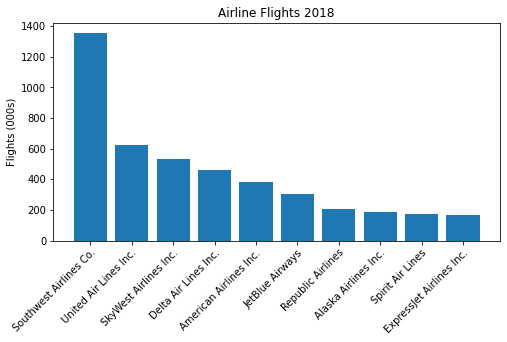

In [ ]:
# plot the top 10 flight counts by airline
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(x, y)

ax.set_ylabel('Flights (000s)')
ax.set_title('Airline Flights 2018')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()